#Step 0 mount your own drive with shared files



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Step 1 import all lib

In [ ]:
import sys
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, utils
import pandas as pd
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt
# %matplotlib notebook
from math import hypot
from itertools import combinations
from sklearn.model_selection import KFold
import gc
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
from tensorflow.keras import regularizers

# Step 2 : Run this Block : 
## Prepare Data : contain 3 functions 

In [ ]:
def create_dataset(X, y):
    features = []
    targets = []
    
    for i in range(0, len(X)): 
        data = [[i] for i in X[i]] # 序列数据  
        label = [y[i]] # 标签数据
        
        # 保存到features和labels
        features.append(data)
        targets.append(label)
    
    # 返回
    return np.array(features), np.array(targets)

In [ ]:
# split data
# x_train, x_test, y_train, y_test

def split_dataset(x, y, train_ratio=0.8):

    x_len = len(x) # 特征数据集X的样本数量
    train_data_len = int(x_len * train_ratio) # 训练集的样本数量
    
    x_train = x[:train_data_len] # 训练集
    y_train = y[:train_data_len] # 训练标签集
    
    x_test = x[train_data_len:] # 测试集
    y_test = y[train_data_len:] # 测试集标签集
    
    # 返回值
    return x_train, x_test, y_train, y_test

# Step 3: Run this Block 
## Model build base on Delete NaN File 
### Need to change file path to your own drive file path

In [ ]:
# set seed
seed = 2

In [ ]:
# set which file to use to build model and what is the grid size
filenum = 1
gsize = 30
shuffle = True

In [ ]:
dataset_x = []
dataset_y = []
import random

with open('/content/drive/MyDrive/ColabNotebooks/{size}mm_file/outfile{fnum}/trainingfile_{size}mm.txt'.format(size = gsize, fnum = filenum), 'r') as f:
    lines = f.readlines()
    if shuffle:
      random.Random(seed).shuffle(lines)
    else:
      pass
    # print(lines[10])
    for line in lines:
        line = line.strip("\n")
        dataset_x.append(line.split("|")[0].split(","))
        dataset_y.append(line.split("|")[1])
        

In [ ]:
len(dataset_x)

81

In [ ]:
dataset_x
lable = [float(y) for y in dataset_y]
input_x = []
for grp in dataset_x:
  input_x.append([float(z) for z in grp])

In [ ]:
input_x,lable = create_dataset(input_x, lable)
x_train, x_test, y_train, y_test = split_dataset(input_x, lable, train_ratio=0.80)

In [ ]:
# input_x

## Data shape

In [ ]:
# input_x.shape
# lable.shape
# print(x_train.shape , x_test.shape)
# print(y_train.shape, y_test.shape)

## LSTM Model

In [ ]:
file_path = "/content/drive/MyDrive/ColabNotebooks/best_checkpoint.hdf5"


earlyStopping=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='auto')
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=file_path, 
                                                         monitor='loss', 
                                                         mode='min', 
                                                         save_best_only=True,
                                                         save_weights_only=True)

learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                            patience=50, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [ ]:
# set paramemaers
# LSTM
lstm_units = 128
acti = 'relu'
drop = 0
regu = None #regularizers.l2(1e-4)
batch = 8
#16！

# optimizer
lr = 0.001
mom = 0.01

#complie
callback_file = [checkpoint_callback, learning_rate_reduction] #[earlyStopping,checkpoint_callback] #None
epo = 1000


In [ ]:
# build model
model = Sequential([
        #LSTM layer
        layers.LSTM(units = lstm_units, 
                    input_shape=(9, 1),
                    activation = acti, 
                    recurrent_activation='sigmoid', 
                    use_bias=True, 
                    kernel_initializer='glorot_uniform', 
                    recurrent_initializer='orthogonal', 
                    bias_initializer='zeros', 
                    unit_forget_bias=True, 
                    kernel_regularizer= regu, 
                    recurrent_regularizer= regu, 
                    bias_regularizer= regu, 
                    activity_regularizer=None, 
                    kernel_constraint=None, 
                    recurrent_constraint=None, 
                    bias_constraint=None, 
                    dropout= drop, 
                    recurrent_dropout=0.0, 
                    implementation=1, 
                    return_sequences=False, 
                    return_state=False, 
                    go_backwards=False, 
                    stateful=False, 
                    unroll=False),
          
          layers.Dense(256, 
                   activation=acti, 
                   use_bias=True, 
                   kernel_initializer='glorot_uniform', 
                   bias_initializer='zeros', 
                   kernel_regularizer=None, 
                   bias_regularizer=None, 
                   activity_regularizer=None, 
                   kernel_constraint=None, 
                   bias_constraint=None),             
          # layers.Dense(128, activation=acti),
          layers.Dense(64, activation=acti), #relu
          layers.Dense(1) #no act
  ])


In [ ]:
opt = keras.optimizers.SGD(learning_rate=lr, momentum= mom, decay=0.0, nesterov= False)

model.compile(
    optimizer=opt,
    loss="mae", #mse
    metrics=None,
    loss_weights=None,
    weighted_metrics=None,
    run_eagerly=None,
    steps_per_execution=None,
)

In [ ]:
import time
start = time.perf_counter()
history = model.fit(
          x_train,
          y_train,
          batch_size=batch,
          epochs=epo,
          verbose="auto",
          callbacks = callback_file,
          validation_split= 0,
          validation_data = (x_test, y_test),
          shuffle= False, 
          class_weight=None,
          sample_weight=None,
          initial_epoch=0,
          steps_per_epoch=None,
          validation_steps=None,
          validation_batch_size=None,
          validation_freq=1,
          max_queue_size=10,
          workers=1,
          use_multiprocessing=False,
      )        

elapsed = time.perf_counter() - start
print('Elapsed %.3f seconds.' % elapsed)


In [ ]:
y_pred = model.predict(x_test, verbose=1)
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
score = r2_score(y_test, y_pred)
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("MAE: ", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("Rsqr:", score)

1/1 [==============================] - 0s 270ms/step
RMSE: 0.8836724924022223
MAE:  0.6000656213709414
MSE: 0.7808770738283557
Rsqr: 0.1232851936962105


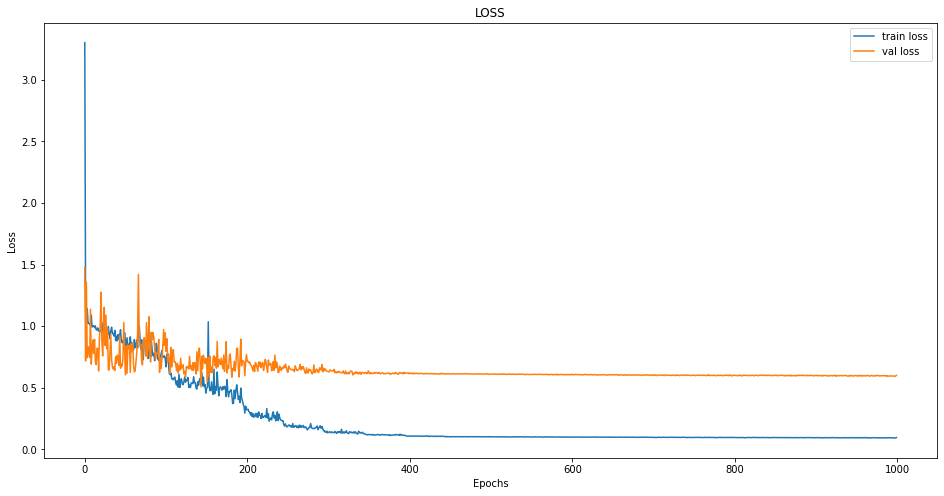

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
# plt.plot(history.history['lr'],  label='lr')
plt.title("LOSS")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

# import pickle
# with open('/content/drive/MyDrive/ColabNotebooks/{size}mm_file/outfile{fnum}/Model_shuff{shuff}_bch{batchsize}_{rscore:.2f}.pickle'.format(size = gsize, fnum = filenum, shuff = str(shuffle), batchsize = batch, rscore = score), 'wb') as file_pi:
#     pickle.dump(history.history, file_pi)
# with open('/content/drive/MyDrive/ColabNotebooks/{size}mm_file/outfile{fnum}/Model_shuff{shuff}_bch{batchsize}_{rscore:.2f}.txt'.format(size = gsize, fnum = filenum, shuff = str(shuffle), batchsize = batch, rscore = score), 'wb') as file_pi:
#     history=pickle.load(file_pi)

# plt.savefig('/content/drive/MyDrive/ColabNotebooks/{size}mm_file/outfile{fnum}/Model_shuff{shuff}_bch{batchsize}_{rscore:.2f}.png'.format(size = gsize, fnum = filenum, shuff = str(shuffle), batchsize = batch, rscore = score), dpi=300)
# Traning loss 代表how well model fit 训练集
# validation loss 代表 how well the model fits 测试集.
# The training loss indicates how well the model is fitting the training data, 
# while the validation loss indicates how well the model fits new data.

In [ ]:
# model.save('/content/drive/MyDrive/ColabNotebooks/{size}mm_file/outfile{fnum}/Model_shuff{shuff}_bch{batchsize}__{rscore:.2f}.h5'.format(size = gsize, fnum = filenum, shuff = str(shuffle), batchsize = batch, rscore = score))

##----------------- No run needed below this line------------------------

In [ ]:
# from sklearn.metrics import r2_score
# print(y_test.shape , y_pred.shape)
# print(y_test)
# print(((y_pred - y_test)/y_test)*100)
# plt.figure(figsize=(160,80))
# plt.plot(y_test, label="True label")
# plt.plot(y_pred, label="Pred label")
# plt.title("True vs Pred")
# plt.legend(loc='best')
# # plt.show()

# y_true = y_test[:2000]
# y_pred = y_pred[:2000]

# plt.figure(figsize=(16,8))
# plt.plot(y_true, marker='o', color='red')
# plt.plot(y_pred, marker='*', color='blue')
# axes[0].plot(y_true, marker='o', color='red')
# axes[1].plot(y_pred, marker='*', color='blue')
# plt.show()

In [ ]:
# fig, axes = plt.subplots(2, 1, figsize=(16,8))
# axes[0].plot(y_true, marker='o', color='red')
# axes[1].plot(y_pred, marker='*', color='blue')

In [ ]:
# from keras.models import load_model

In [ ]:
# new_model = load_model("/content/drive/MyDrive/ColabNotebooks/saved_model/model_20mm_4batch.h5")

In [ ]:
# y_pred2 = new_model.predict(x_test, verbose=1)
# from sklearn.metrics import mean_squared_error
# score = r2_score(y_test, y_pred2)
# print("RMSE:", mean_squared_error(y_test, y_pred2, squared=False))
# print("MSE:", mean_squared_error(y_test, y_pred2))
# print("Rsqr:",score)

In [ ]:
# score = r2_score(y_test, y_pred2)
# print(score)


In [ ]:
# score = r2_score(y_test, y_pred)
# score

In [ ]:
# import h5py
# f = h5py.File('best_checkpoint.hdf5','r')   #打开h5文件  # 可以查看所有的主键  
# for key in f.keys():      
#   print(f[key].name)
#   # print(f[key].value) 

## 5 fold validation

In [ ]:
# # input_x,lable_1d = create_dataset(input_x, lable)
# # lable = np.array(lable)
# fold = 5
# kf = KFold(n_splits=fold, shuffle = True, random_state=seed)
# # kf.get_n_splits(input_x)
# # print(kf)
# from keras import backend as K 
# K.clear_session()
# from sklearn.metrics import r2_score
# for train_idx, test_idx in kf.split(input_x,lable):
#   # print(train_idx)
#   x_train, x_test = input_x[train_idx], input_x[test_idx]
#   y_train, y_test = lable[train_idx], lable[test_idx]
#   # print("x_1:", x_train.shape, "y_1:", y_train.shape)
#   model = Sequential([
#                       layers.LSTM(64, input_shape=(9, 1)),
#                       layers.Dense(256),
#                       layers.Dense(128),
#                       layers.Dense(64), #relu
#                       layers.Dense(1) #no act
#                       ])
#   opt = keras.optimizers.SGD(learning_rate=0.01) #SGD
#   model.compile(optimizer = opt, loss="mae") #or mse
#   history = model.fit(x_train, y_train, epochs=10, batch_size = 128, validation_data = (x_test, y_test))
#   y_pred = model.predict(x_test, verbose=1)
#   score = r2_score(y_test, y_pred)
#   # print("y_test",y_test)
#   # print("y_pred", y_pred)
#   print(score)
#   # scores = model.evaluate(x_test, y_test, batch_size = 128)
#   # print("train loss",history.history['loss'])
#   # print("validation loss",history.history['val_loss'])

# LSTM Model Background Knowledge

# data with NaN

In [ ]:
# f_error = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/error.txt')
# gin = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/fin_python.txt')

# # f_error
# f_error = f_error.sort_values(by = ['center_y','center_x'], ascending = (False, True))
# d = 2
# r = (d**2 + d**2)**0.5
# d_xl = 2*3
# x_axis = np.arange(-170,170,d)
# y_axis = np.arange(-170,170,d)
# X,Y = np.meshgrid(x_axis,y_axis)

# plt.plot(X,Y, marker='+', color='grey', linestyle='none',alpha=0.2)
# plt.plot(f_error['center_x'],f_error['center_y'], marker='.',markersize=0.4, color='red', linestyle='none')
# plt.gca().set_aspect('equal') #set same ratio for x and y axis
# plt.show()
# gin.head()
# len(f_error['center_y'].value_counts())
# y_cord = 169
# row = 0
# arr = []
# arr_col = []
# while y_cord >= -169:
#     arr += [row]*len(f_error[f_error['center_y']==y_cord])
#     for col in range(0,len(f_error[f_error['center_y']==y_cord])):
#         arr_col += [col]
    
#     y_cord -= 2
#     row += 1
    
# arr = pd.DataFrame(arr[::-1], columns = ["row"])
# f_error['row'] = arr

# f_error['col'] = arr_col

# # f_error = f_error[f_error['error'].notna()]
# f_error
# row = 0
# z_matrix = []
# error_matrix = []

# while row <= f_error['row'].max():
#     pt = f_error[f_error['row']==row]
#     grid_cordinate = list(pt['center_z'])
#     z_matrix.append(grid_cordinate)
    
#     error_cordinate = list(pt['error'])
#     error_matrix.append(error_cordinate)
#     row += 1

# from itertools import zip_longest
# # pd.DataFrame(point_matrix)
# error_matrix = np.array(list(zip_longest(*error_matrix, fillvalue= np.nan)))
# # z_matrix = np.array(list(zip_longest(*z_matrix, fillvalue= z_matrix[len(z_matrix)-1])))
# z_matrix = np.array(list(zip_longest(*z_matrix, fillvalue= 0)))
# error_matrix.shape
# z_matrix.shape

# def rolling_window(a, shape):
#     s = (a.shape[0] - shape[0] + 1,) + (a.shape[1] - shape[1] + 1,) + shape
#     strides = a.strides + a.strides
#     return np.lib.stride_tricks.as_strided(a, shape=s, strides=strides)

# def window2(arr, shape=(3, 3)):
#     r_extra = np.floor(shape[0] / 2).astype(int)
#     c_extra = np.floor(shape[1] / 2).astype(int)
#     out = np.empty((arr.shape[0] + 2 * r_extra, arr.shape[1] + 2 * c_extra))
#     out[:] = np.nan
#     out[r_extra:-r_extra, c_extra:-c_extra] = arr
#     view = rolling_window(out, shape)
# #     print(rolling_window(out, shape))
#     return view

# # window2(z_matrix,(3,3))
# error_sqmatrix = window2(error_matrix,(3,3))
# z_sqmatrix = window2(z_matrix,(3,3))

# # z_sqmatrix.shape
# # output:(170, 170, 3, 3)

# # z_sqmatrix
# model_x = []
# import itertools
# for row in z_sqmatrix:
#     for col in row:
# #         print(list(itertools.chain.from_iterable(col)))
#         model_x.append(list(itertools.chain.from_iterable(col)))
    

# # model_x
# model_x = np.array(model_x)
# model_x.shape
# model_y = []

# for row in error_sqmatrix:
#     for col in row:
# #     for col_idx in range(0,3):
# #         print(list(itertools.chain.from_iterable(col)))
#         model_y.append(list(itertools.chain.from_iterable(col))[4])
    
# # model_x
# model_y = np.array(model_y)
# model_y.shape
# # model_x = np.nan_to_num(model_x)
# # model_y = np.nan_to_num(model_y,nan = f_error['error'].mean())
# model_x[0]
# model_y[0]

**1. LSTM函数：**

https://keras.io/zh/layers/recurrent/#lstm

```
keras.layers.LSTM(units, 
                  activation='tanh', 
                  recurrent_activation='hard_sigmoid', 
                  use_bias=True, 
                  kernel_initializer='glorot_uniform', 
                  recurrent_initializer='orthogonal', 
                  bias_initializer='zeros', 
                  unit_forget_bias=True, 
                  kernel_regularizer=None, 
                  recurrent_regularizer=None, 
                  bias_regularizer=None, 
                  activity_regularizer=None, 
                  kernel_constraint=None, 
                  recurrent_constraint=None, 
                  bias_constraint=None, 
                  dropout=0.0, 
                  recurrent_dropout=0.0, 
                  implementation=1, 
                  return_sequences=False, 
                  return_state=False, 
                  go_backwards=False, 
                  stateful=False, 
                  unroll=False)

```



**2. Sequential函数: model = Sequential()**

https://keras.io/zh/getting-started/sequential-model-guide/

<br>

**3. Complie函数：**

<br>

<b> Definition: </b><br>
模型编译<br>

<b> Parameters: </b><br>
* 优化器 optimizer。它可以是现有优化器的字符串标识符，如 rmsprop 或 adagrad，也可以是 Optimizer 类的实例。详见：optimizers。

* 损失函数 loss，模型试图最小化的目标函数。它可以是现有损失函数的字符串标识符，如 categorical_crossentropy 或 mse，也可以是一个目标函数。详见：losses。
* 评估标准 metrics。评估标准可以是现有的标准的字符串标识符，也可以是自定义的评估标准函数。



**4. Dense函数：keras.layers.Dense()**

https://keras.io/zh/layers/core/#dense/

<br>
<b> Definition: </b><br>

Dense 实现以下操作： 
output = activation(dot(input, kernel) + bias) 其中 activation 
是按逐个元素计算的激活函数，kernel 是由网络层创建的权值矩阵，以及 bias 是其创建的偏置向量

```
keras.layers.Dense(units, 
                   activation=None, 
                   use_bias=True, 
                   kernel_initializer='glorot_uniform', 
                   bias_initializer='zeros', 
                   kernel_regularizer=None, 
                   bias_regularizer=None, 
                   activity_regularizer=None, 
                   kernel_constraint=None, 
                   bias_constraint=None)
```

<b> Parameters: </b><br>
* units: 正整数，输出空间维度。

* activation: 激活函数 (详见 activations)。 若不指定，则不使用激活函数 (即，「线性」激活: a(x) = x)。
* use_bias: 布尔值，该层是否使用偏置向量。
* kernel_initializer: kernel 权值矩阵的初始化器 (详见 initializers)。
* bias_initializer: 偏置向量的初始化器 (see initializers).
* kernel_regularizer: 运用到 kernel 权值矩阵的正则化函数 (详见 regularizer)。
* bias_regularizer: 运用到偏置向的的正则化函数 (详见 regularizer)。
* activity_regularizer: 运用到层的输出的正则化函数 (它的 "activation")。 (详见 regularizer)。
* kernel_constraint: 运用到 kernel 权值矩阵的约束函数 (详见 constraints)。
* bias_constraint: 运用到偏置向量的约束函数 (详见 constraints)。<br>

>